In [1]:
import config
from model_CNV import CNV

import numpy as np
import torch
from torchinfo import summary

from brevitas.export import export_qonnx

# Folders setup

In [2]:
models_folder = config.MODELS_FOLDER

# Model setup

In [3]:
brevitas_model = CNV().to('cpu')
brevitas_model.eval();

In [4]:
summary(brevitas_model, input_size=(1, config.NUM_CHANNELS, config.IMG_H, config.IMG_W))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Layer (type:depth-idx)                                                      Output Shape              Param #
CNV                                                                         [1, 2]                    --
├─ModuleList: 1-53                                                          --                        (recursive)
│    └─QuantIdentity: 2-1                                                   [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                  [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                  [1, 3, 224, 224]          --
├─ModuleList: 1-54                                                          --                        (recursive)
│    └─QuantLinear: 2-95                                                    --                        (recursive)
│    │    └─WeightQuantProxyFromInjector: 3-118                             --                        (recursive)
├─ModuleList: 

In [5]:
test_ip_numpy = np.random.randint(low=0, high=256, size=(1, config.NUM_CHANNELS, config.IMG_H, config.IMG_W))
test_ip = torch.tensor((test_ip_numpy / 255.), dtype=torch.float32).to('cuda')
test_ip.shape

torch.Size([1, 3, 224, 224])

In [6]:
brevitas_model.to('cuda')
test_out = brevitas_model(test_ip)
brevitas_model.to('cpu');

In [7]:
print(test_out.shape)

torch.Size([1, 2])


### Model to QONNX

In [8]:
#brevitas_model.to('cpu');

In [9]:
brevitas_cpu = models_folder + '00_brevitas_cpu.onnx'
export_qonnx(brevitas_model, torch.randn((1, config.NUM_CHANNELS, config.IMG_H, config.IMG_W)), brevitas_cpu);

In [10]:
# brevitas_model.to('cuda')
# brevitas_cuda = models_folder + '00_brevitas_cuda.onnx'

# export_qonnx(brevitas_model, torch.randn((1, config.NUM_CHANNELS, config.IMG_H, config.IMG_W)).to('cuda'), brevitas_cuda);

# Model Clean

In [11]:
from finn.util.visualization import showSrc, showInNetron
from qonnx.util.cleanup import cleanup as qonnx_cleanup

In [12]:
qonnx_clean_filename = models_folder + '01_clean.onnx'
qonnx_cleanup(brevitas_cpu, out_file=qonnx_clean_filename)

In [13]:
#showInNetron(brevitas_cpu)

In [14]:
#showInNetron(qonnx_clean_filename)

# Compare All Outputs

In [15]:
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe

In [16]:
test_ip = np.random.randint(low=0, high=256, size=(1, config.NUM_CHANNELS, config.IMG_H, config.IMG_W)) / 255.
test_ip = test_ip.astype(np.float32)
test_ip_torch = torch.tensor(test_ip, dtype=torch.float32).to('cpu')

In [17]:
torch_out = brevitas_model(test_ip_torch)
torch_out

tensor([[1., 1.]], grad_fn=<MulBackward0>)

In [18]:
from qonnx.transformation.infer_shapes import InferShapes

In [19]:
ori_model = ModelWrapper(brevitas_cpu)
ori_model = ori_model.transform(InferShapes())

brevitas_shapes = models_folder + '00_brevitas_cpu_shapes.onnx'
ori_model.save(brevitas_shapes)

In [20]:
ori_model = ModelWrapper(brevitas_shapes)
clean_model = ModelWrapper(qonnx_clean_filename)

In [21]:
input_dict = {"global_in": test_ip}
# output_dict = oxe.execute_onnx(ori_model, input_dict)
# produced_ori_qonnx = output_dict[list(output_dict.keys())[0]]
# produced_ori_qonnx

In [22]:
output_dict = oxe.execute_onnx(clean_model, input_dict)
produced_clean_qonnx = output_dict[list(output_dict.keys())[0]]
produced_clean_qonnx

array([[1., 1.]], dtype=float32)

# Convert to FINN

In [23]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

In [24]:
model = ModelWrapper(qonnx_clean_filename)
model = model.transform(ConvertQONNXtoFINN())
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())

In [25]:
finn_tidy = models_folder + '02_finn_tidy.onnx'
model.save(finn_tidy)

In [26]:
showInNetron(finn_tidy)

Serving 'experiments/02_w4a8_folding/models/02_finn_tidy.onnx' at http://0.0.0.0:8083


### Count Number of Convs and Number of FC (MatMul)

In [75]:
model = ModelWrapper(finn_tidy)

n_CONV = 0
n_FC = 0
graph = model.graph
for node in graph.node:
    if node.op_type == "Conv":
        n_CONV += 1
    elif node.op_type == "MatMul":
        n_FC += 1

print(f'Number of convolutions: {n_CONV}')
print(f'Number of fully connected: {n_FC}')

Number of convolutions: 12
Number of fully connected: 2


# PreProcess

In [27]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

model = ModelWrapper(finn_tidy)
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = models_folder + "./prepro_node.onnx"
export_qonnx(totensor_pyt, torch.randn(ishape), chkpt_preproc_name)
qonnx_cleanup(chkpt_preproc_name, out_file=chkpt_preproc_name)
pre_model = ModelWrapper(chkpt_preproc_name)
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

/home/gmoreno/uav/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [28]:
from qonnx.transformation.infer_datatypes import InferDataTypes

### Save prepro again after tidy

In [29]:
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

In [30]:
finn_prepro = models_folder + '03_finn_prepro.onnx'
model.save(finn_prepro)

In [31]:
showInNetron(finn_prepro)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/03_finn_prepro.onnx' at http://0.0.0.0:8083


# Streamline

In [32]:
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from qonnx.transformation.change_datalayout import ChangeDataLayoutQuantAvgPool2d
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

from finn.transformation.streamline import Streamline
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants

In [76]:
model = ModelWrapper(finn_prepro)
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(ChangeDataLayoutQuantAvgPool2d())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(Streamline())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

In [77]:
finn_streamline = models_folder + '04_finn_streamline.onnx'
model.save(finn_streamline)

In [78]:
showInNetron(finn_streamline)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/04_finn_streamline.onnx' at http://0.0.0.0:8083


# HW Layers

In [36]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten

from qonnx.custom_op.registry import getCustomOp

In [37]:
model = ModelWrapper(finn_streamline)
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())

# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())
model = model.transform(to_hw.InferPool())
model = model.transform(to_hw.InferStreamingMaxPool())
model = model.transform(to_hw.InferConvInpGen())

# get rid of Reshape(-1, 1) operation between hw nodes 
model = model.transform(RemoveCNVtoFCFlatten())

# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())

# infer tensor data layouts
model = model.transform(InferDataLayouts())

model = model.transform(Streamline())

In [38]:
finn_hw_layers = models_folder + '10_fin_hw_layers.onnx'
model.save(finn_hw_layers)

In [79]:
showInNetron(finn_hw_layers)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/10_fin_hw_layers.onnx' at http://0.0.0.0:8083


# Dataflow Partition

In [40]:
model = ModelWrapper(finn_hw_layers)
parent_model = model.transform(CreateDataflowPartition())

In [41]:
finn_parent_filename = models_folder + '11_finn_dataflow_parent.onnx'
parent_model.save(finn_parent_filename)

In [42]:
showInNetron(finn_parent_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/11_finn_dataflow_parent.onnx' at http://0.0.0.0:8083


In [43]:
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_filename = sdp_node.get_nodeattr("model")
dataflow_model = ModelWrapper(dataflow_filename)

In [44]:
print(dataflow_filename)

/home/gmoreno/workspace/dataflow_partition_u5xfufwe/partition_0.onnx


# FPGA Board

In [45]:
from finn.util.basic import pynq_part_map
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 10

In [46]:
import pandas as pd

In [47]:
fpga_df = pd.DataFrame(pynq_part_map.items(), columns=['Board', 'FPGA Part'])
fpga_df

,Board,FPGA Part
0,Ultra96,xczu3eg-sbva484-1-e
1,Ultra96-V2,xczu3eg-sbva484-1-i
2,Pynq-Z1,xc7z020clg400-1
3,Pynq-Z2,xc7z020clg400-1
4,ZCU102,xczu9eg-ffvb1156-2-e
5,ZCU104,xczu7ev-ffvc1156-2-e
6,ZCU111,xczu28dr-ffvg1517-2-e
7,RFSoC2x2,xczu28dr-ffvg1517-2-e
8,RFSoC4x2,xczu48dr-ffvg1517-2-e
9,KV260_SOM,xck26-sfvc784-2LV-c


In [48]:
print(f'FPGA chosen: \n\tBoard: {pynq_board}\n\tPart: {fpga_part}')

FPGA chosen: 
	Board: Pynq-Z1
	Part: xc7z020clg400-1


# Specialize Layers

In [49]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers

In [50]:
test_graph = dataflow_model.graph

In [51]:
for node in test_graph.node:
    if node.op_type == "FMPadding":   
        node_inst = getCustomOp(node)
        node_inst.set_nodeattr("preferred_impl_style", "hls")
        print(f'Node {node.name} forced to HLS implementation')

Node FMPadding_0 forced to HLS implementation
Node FMPadding_1 forced to HLS implementation
Node FMPadding_2 forced to HLS implementation
Node FMPadding_3 forced to HLS implementation
Node FMPadding_4 forced to HLS implementation
Node FMPadding_5 forced to HLS implementation
Node FMPadding_6 forced to HLS implementation


In [52]:
# FMPadding_node = dataflow_model.get_nodes_by_op_type("FMPadding")
# i = 0
# for node in FMPadding_node:
#     node_inst = getCustomOp(node)
#     node_inst.set_nodeattr("preferred_impl_style", "hls")
#     print(f'Node {i}: {node}')
#     i += 1

In [53]:
# save the dataflow partition with a different name for easier access
# and specialize the layers to HLS variants
dataflow_model = dataflow_model.transform(SpecializeLayers(fpga_part))

dataflow_model = dataflow_model.transform(GiveUniqueNodeNames())
dataflow_model = dataflow_model.transform(GiveReadableTensorNames())

finn_dataflow_filename = models_folder + '20_finn_dataflow_model.onnx'
dataflow_model.save(finn_dataflow_filename)

In [54]:
showInNetron(finn_dataflow_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/20_finn_dataflow_model.onnx' at http://0.0.0.0:8083


### Check execution???

In [55]:
# parent_dataflow_model = ModelWrapper(finn_parent_filename)

In [56]:
# input_dict = {"global_in": test_ip*255}
# output_dict = oxe.execute_onnx(parent_dataflow_model, input_dict)
# produced_clean_qonnx = output_dict[list(output_dict.keys())[0]]
# produced_clean_qonnx

# Folding Factors Analysis

At this point, PE and SIMD = 1, default values, for all MVAU.

However, it PE = in_channels for other layers.

In [57]:
from functools import partial
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.analysis.fpgadataflow.res_estimation import res_estimation

In [80]:
model = ModelWrapper(finn_dataflow_filename)
model = model.transform(GiveUniqueNodeNames())

before_analysis_filename = models_folder + '21_dataflow_before_analysis.onnx'
model.save(before_analysis_filename)

In [81]:
showInNetron(before_analysis_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/21_dataflow_before_analysis.onnx' at http://0.0.0.0:8083


## Estimated Cycles

In [82]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'Thresholding_rtl_0': 150528,
 'FMPadding_hls_0': 51076,
 'ConvolutionInputGenerator_rtl_0': 452039,
 'MVAU_hls_0': 43352064,
 'ConvolutionInputGenerator_rtl_1': 50626,
 'Pool_hls_0': 50176,
 'FMPadding_hls_1': 12996,
 'ConvolutionInputGenerator_rtl_2': 113127,
 'MVAU_hls_1': 57802752,
 'ConvolutionInputGenerator_rtl_3': 12770,
 'Pool_hls_1': 12544,
 'MVAU_hls_2': 802816,
 'FMPadding_hls_2': 3364,
 'ConvolutionInputGenerator_rtl_4': 28343,
 'MVAU_hls_3': 14450688,
 'MVAU_hls_4': 3211264,
 'FMPadding_hls_3': 3364,
 'ConvolutionInputGenerator_rtl_5': 28343,
 'MVAU_hls_5': 57802752,
 'ConvolutionInputGenerator_rtl_6': 3250,
 'Pool_hls_2': 3136,
 'MVAU_hls_6': 1605632,
 'FMPadding_hls_4': 900,
 'ConvolutionInputGenerator_rtl_7': 7119,
 'MVAU_hls_7': 14450688,
 'MVAU_hls_8': 1605632,
 'FMPadding_hls_5': 900,
 'ConvolutionInputGenerator_rtl_8': 7119,
 'MVAU_hls_9': 14450688,
 'MVAU_hls_10': 1605632,
 'FMPadding_hls_6': 900,
 'ConvolutionInputGenerator_rtl_9': 7119,
 'MVAU_hls_11': 14450688,

### Total Latency

In [83]:
latency = 0
for val in cycles_dict.values():
    latency += val
print(f'Total latency = {latency}')

Total latency = 226595199


### Plot Cycles

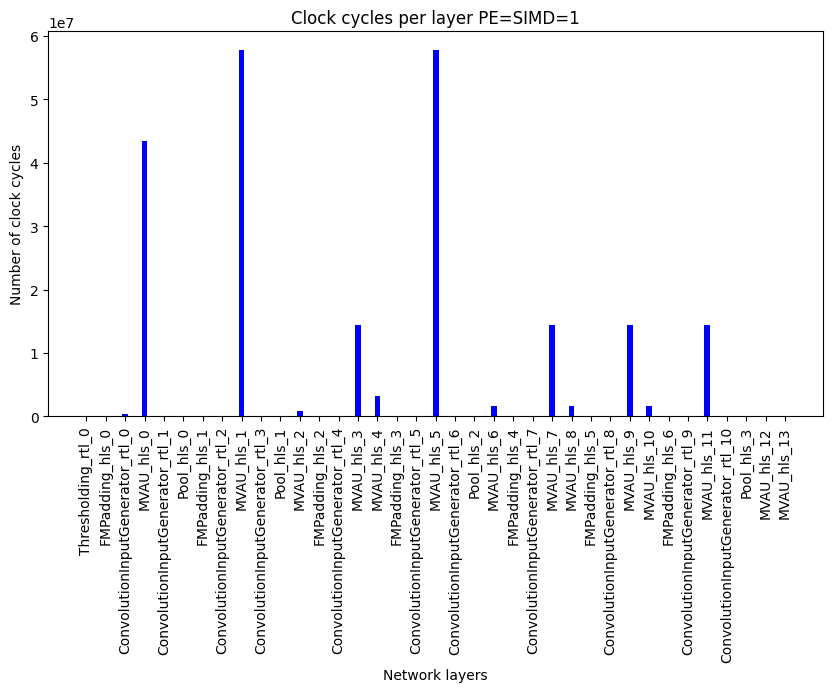

In [84]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of clock cycles")
plt.title("Clock cycles per layer PE=SIMD=1")
plt.show()

## Estimated Resources

In [85]:
res_dict = model.analysis(partial(res_estimation, fpgapart=fpga_part))
res_dict

{'Thresholding_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 128.0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 588,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.1875,
  'LUT': 370,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 3372,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'Pool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_2': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 2092,
  'URAM': 0,
 

### BRAM usage

In [96]:
BRAM = {key: res_dict[key]["BRAM_18K"] for key in res_dict.keys() if res_dict[key]["BRAM_18K"] != 0}

n_BRAM = 0
for k, v in BRAM.items():
    print(f'{k:<14} {v} BRAM')
    n_BRAM += v
print(f'\nTotal BRAM = {n_BRAM}')

MVAU_hls_0     1 BRAM
MVAU_hls_1     2 BRAM
MVAU_hls_2     1 BRAM
MVAU_hls_3     2 BRAM
MVAU_hls_4     1 BRAM
MVAU_hls_5     5 BRAM
MVAU_hls_6     1 BRAM
MVAU_hls_7     5 BRAM
MVAU_hls_8     1 BRAM
MVAU_hls_9     5 BRAM
MVAU_hls_10    1 BRAM
MVAU_hls_11    5 BRAM
MVAU_hls_12    1 BRAM
MVAU_hls_13    1 BRAM

Total BRAM = 32


### LUT usage

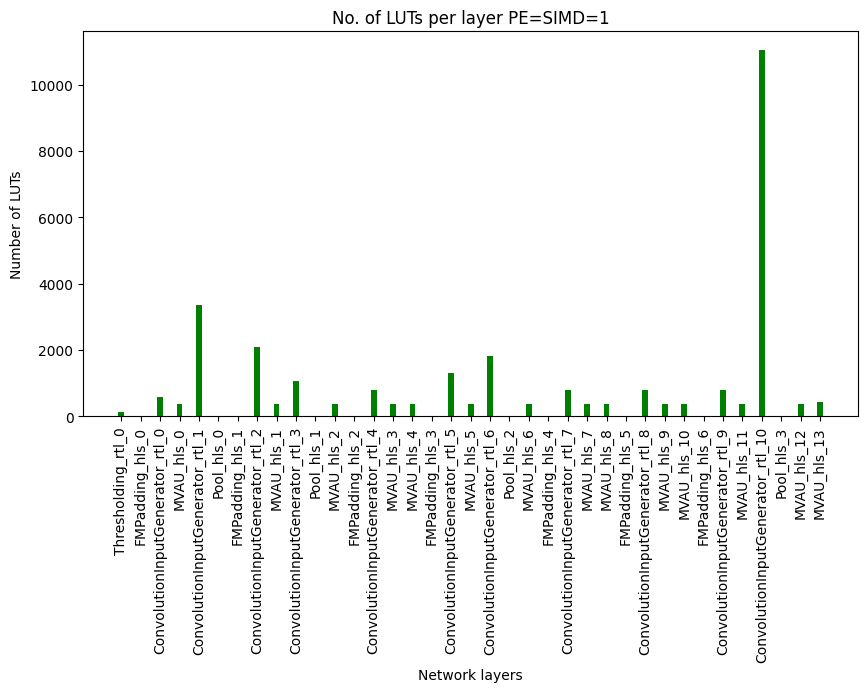

In [98]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of LUTs")
plt.title("No. of LUTs per layer PE=SIMD=1")
plt.show()

# Folding Factors Streamline: mvau_wwidth_max=36

In [99]:
from finn.transformation.fpgadataflow.set_folding import SetFolding

**Taregt Cycles Per Frame**

If target is 25 FPS, inference time is $\frac{1}{25}=40ms$

If $clk = 10 ns$:
$$
Target~Cycles~Per~Frame = \frac{40\times 10^{-3}}{10\times 10^{-9}}= 4\times 10^{6}
$$

No se tiene en cuenta el tiempo de preprocesado, que en realidad debería ser inexistente, ya que está embebido en el preprocess del modelo. 

In [134]:
# model = ModelWrapper(finn_dataflow_filename)
model = ModelWrapper(before_analysis_filename)

apply method of SetFolding returns (model, False), so model is [0]

maybe it is easier to do: model, _ = folder.apply(...)

If model.transform is used, there is no need for above manipulation

In [135]:
model = model.transform(SetFolding(
    target_cycles_per_frame=4000000,#1000,
    mvau_wwidth_max=36,
    two_pass_relaxation=True)
)

In [136]:
folding_filename = models_folder + '30_finn_folding.onnx'
model.save(folding_filename)

In [137]:
showInNetron(folding_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/30_finn_folding.onnx' at http://0.0.0.0:8083


## Estimated Cycles

In [138]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'Thresholding_rtl_0': 150528,
 'FMPadding_hls_0': 153228,
 'ConvolutionInputGenerator_rtl_0': 1356117,
 'MVAU_hls_0': 1605632,
 'ConvolutionInputGenerator_rtl_1': 2008896,
 'Pool_hls_0': 1605632,
 'FMPadding_hls_1': 415872,
 'ConvolutionInputGenerator_rtl_2': 3620064,
 'MVAU_hls_1': 3211264,
 'ConvolutionInputGenerator_rtl_3': 251360,
 'Pool_hls_1': 200704,
 'MVAU_hls_2': 802816,
 'FMPadding_hls_2': 53824,
 'ConvolutionInputGenerator_rtl_4': 453488,
 'MVAU_hls_3': 3612672,
 'MVAU_hls_4': 3211264,
 'FMPadding_hls_3': 107648,
 'ConvolutionInputGenerator_rtl_5': 906976,
 'MVAU_hls_5': 3211264,
 'ConvolutionInputGenerator_rtl_6': 257392,
 'Pool_hls_2': 200704,
 'MVAU_hls_6': 1605632,
 'FMPadding_hls_4': 28800,
 'ConvolutionInputGenerator_rtl_7': 227808,
 'MVAU_hls_7': 3612672,
 'MVAU_hls_8': 1605632,
 'FMPadding_hls_5': 28800,
 'ConvolutionInputGenerator_rtl_8': 227808,
 'MVAU_hls_9': 3612672,
 'MVAU_hls_10': 1605632,
 'FMPadding_hls_6': 28800,
 'ConvolutionInputGenerator_rtl_9': 227808,


### Total Latency

In [139]:
latency = 0
for val in cycles_dict.values():
    latency += val
print(f'Total latency = {latency}')

Total latency = 44023750


### Plot Cycles

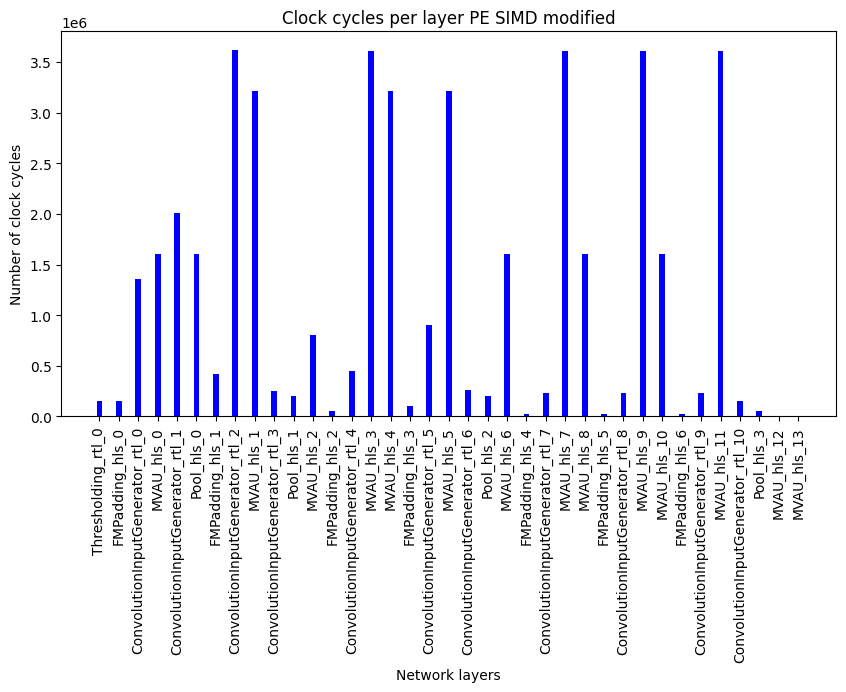

In [140]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of clock cycles")
plt.title("Clock cycles per layer PE SIMD modified")
plt.show()

## Estimated Resources

In [141]:
res_dict = model.analysis(partial(res_estimation, fpgapart=fpga_part))
res_dict

{'Thresholding_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 128.0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 588,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 3,
  'BRAM_efficiency': 0.0625,
  'LUT': 2086,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 3308,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'Pool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_2': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 1860,
  'URAM': 0,


### BRAM usage

In [142]:
BRAM = {key: res_dict[key]["BRAM_18K"] for key in res_dict.keys() if res_dict[key]["BRAM_18K"] != 0}

n_BRAM = 0
for k, v in BRAM.items():
    print(f'{k:<14} {v} BRAM')
    n_BRAM += v
print(f'\nTotal BRAM = {n_BRAM}')

MVAU_hls_0     3 BRAM
MVAU_hls_1     2 BRAM
MVAU_hls_2     1 BRAM
MVAU_hls_3     2 BRAM
MVAU_hls_4     1 BRAM
MVAU_hls_5     4 BRAM
MVAU_hls_6     1 BRAM
MVAU_hls_7     5 BRAM
MVAU_hls_8     1 BRAM
MVAU_hls_9     5 BRAM
MVAU_hls_10    1 BRAM
MVAU_hls_11    5 BRAM
MVAU_hls_12    1 BRAM
MVAU_hls_13    1 BRAM

Total BRAM = 33


### LUT usage

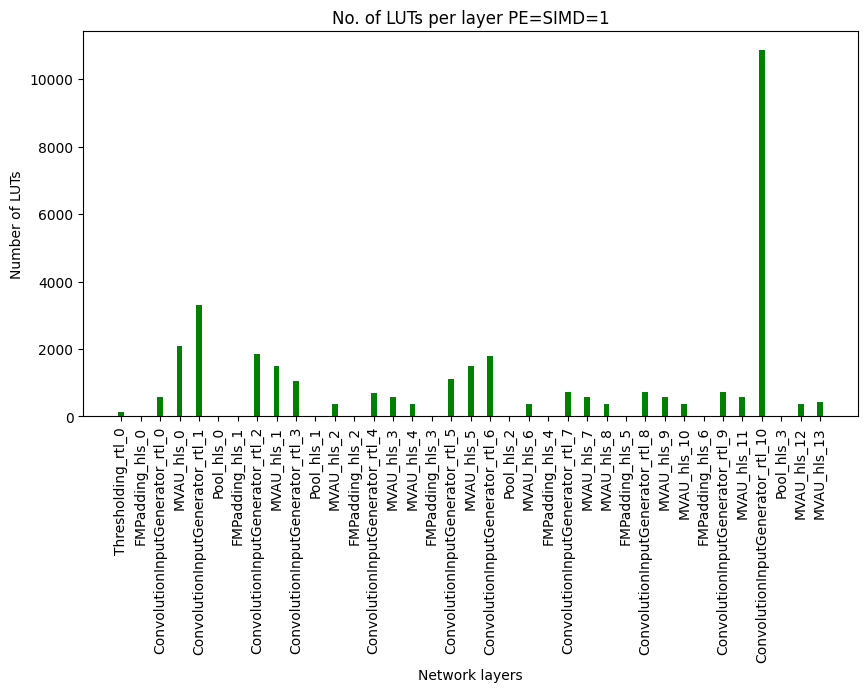

In [143]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of LUTs")
plt.title("No. of LUTs per layer PE=SIMD=1")
plt.show()

### Total LUT usage

In [146]:
lut_total = 0
for lut_val in LUTs:
    lut_total += lut_val
print(f'Total number of LUTs = {lut_total}')

Total number of LUTs = 33658.0


# Folding Factor Streamline: mvau_wwidth_max=10000 

In [114]:
model = ModelWrapper(before_analysis_filename)

In [115]:
model = model.transform(SetFolding(
    target_cycles_per_frame=4000000,
    mvau_wwidth_max=10000,
    two_pass_relaxation=True)
)

In [116]:
folding_2_filename = models_folder + '30_finn_folding_mvau10000.onnx'
model.save(folding_2_filename)

In [117]:
showInNetron(folding_2_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/30_finn_folding_mvau10000.onnx' at http://0.0.0.0:8083


## Estimated Cycles

In [118]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'Thresholding_rtl_0': 150528,
 'FMPadding_hls_0': 153228,
 'ConvolutionInputGenerator_rtl_0': 1356117,
 'MVAU_hls_0': 1605632,
 'ConvolutionInputGenerator_rtl_1': 2008896,
 'Pool_hls_0': 1605632,
 'FMPadding_hls_1': 415872,
 'ConvolutionInputGenerator_rtl_2': 3620064,
 'MVAU_hls_1': 3612672,
 'ConvolutionInputGenerator_rtl_3': 251360,
 'Pool_hls_1': 200704,
 'MVAU_hls_2': 802816,
 'FMPadding_hls_2': 53824,
 'ConvolutionInputGenerator_rtl_4': 453488,
 'MVAU_hls_3': 3612672,
 'MVAU_hls_4': 3211264,
 'FMPadding_hls_3': 107648,
 'ConvolutionInputGenerator_rtl_5': 906976,
 'MVAU_hls_5': 3612672,
 'ConvolutionInputGenerator_rtl_6': 257392,
 'Pool_hls_2': 200704,
 'MVAU_hls_6': 1605632,
 'FMPadding_hls_4': 28800,
 'ConvolutionInputGenerator_rtl_7': 227808,
 'MVAU_hls_7': 3612672,
 'MVAU_hls_8': 1605632,
 'FMPadding_hls_5': 28800,
 'ConvolutionInputGenerator_rtl_8': 227808,
 'MVAU_hls_9': 3612672,
 'MVAU_hls_10': 1605632,
 'FMPadding_hls_6': 28800,
 'ConvolutionInputGenerator_rtl_9': 227808,


### Total Latency

In [119]:
latency = 0
for val in cycles_dict.values():
    latency += val
print(f'Total latency = {latency}')

Total latency = 44826566


### Plot Cycles

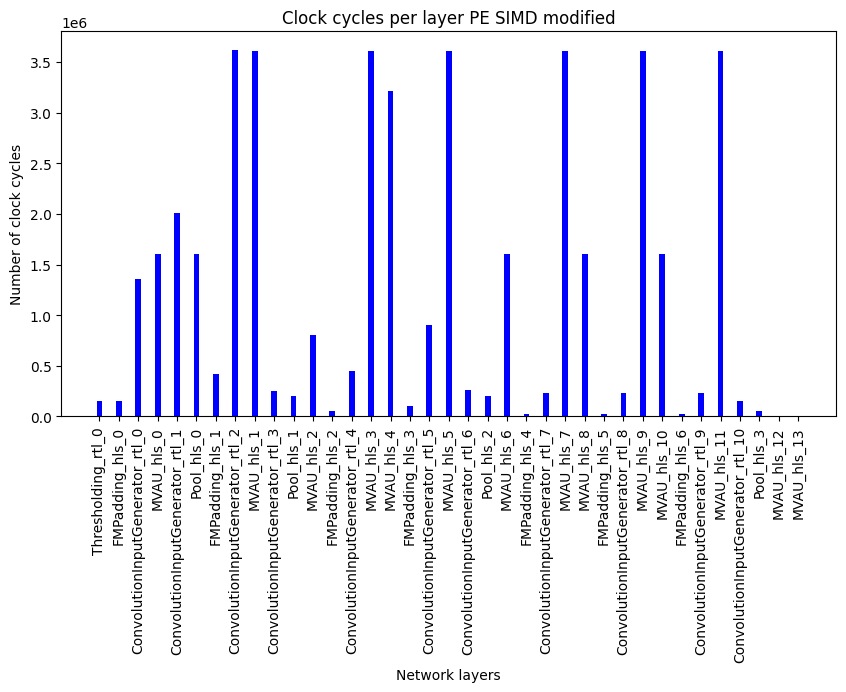

In [120]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of clock cycles")
plt.title("Clock cycles per layer PE SIMD modified")
plt.show()

## Estimated Resources

In [121]:
res_dict = model.analysis(partial(res_estimation, fpgapart=fpga_part))
res_dict

{'Thresholding_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 128.0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 588,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 3,
  'BRAM_efficiency': 0.0625,
  'LUT': 2086,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 3308,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'Pool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_2': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 1860,
  'URAM': 0,


### BRAM usage

In [122]:
BRAM = {key: res_dict[key]["BRAM_18K"] for key in res_dict.keys() if res_dict[key]["BRAM_18K"] != 0}

n_BRAM = 0
for k, v in BRAM.items():
    print(f'{k:<14} {v} BRAM')
    n_BRAM += v
print(f'\nTotal BRAM = {n_BRAM}')

MVAU_hls_0     3 BRAM
MVAU_hls_1     2 BRAM
MVAU_hls_2     1 BRAM
MVAU_hls_3     2 BRAM
MVAU_hls_4     1 BRAM
MVAU_hls_5     8 BRAM
MVAU_hls_6     1 BRAM
MVAU_hls_7     5 BRAM
MVAU_hls_8     1 BRAM
MVAU_hls_9     5 BRAM
MVAU_hls_10    1 BRAM
MVAU_hls_11    5 BRAM
MVAU_hls_12    1 BRAM
MVAU_hls_13    1 BRAM

Total BRAM = 37


### LUT usage

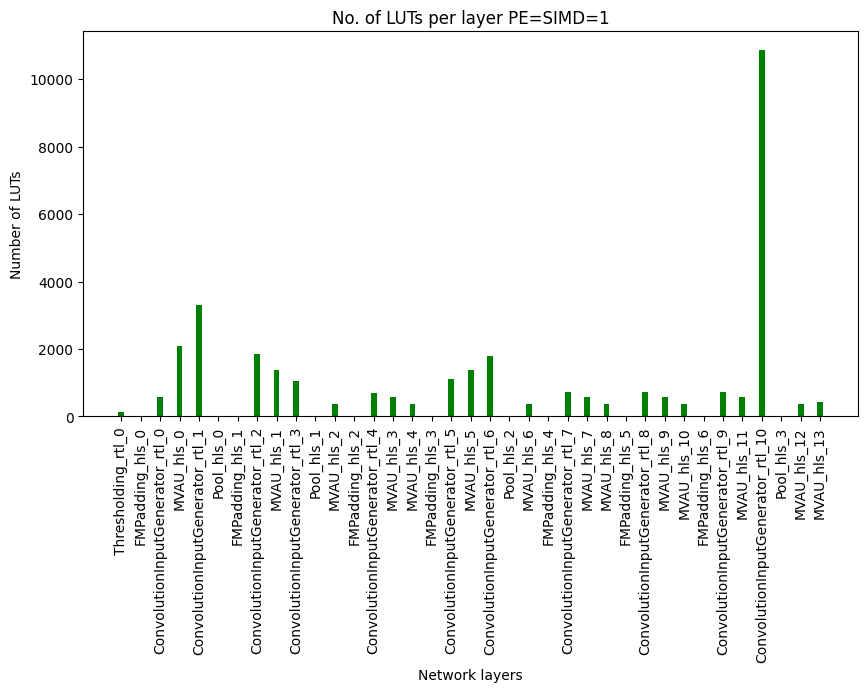

In [123]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of LUTs")
plt.title("No. of LUTs per layer PE=SIMD=1")
plt.show()

# Folding Factor Streamline: mvau_wwidth_max=80

In [124]:
model = ModelWrapper(before_analysis_filename)

In [125]:
model = model.transform(SetFolding(
    target_cycles_per_frame=4000000,
    mvau_wwidth_max=80,
    two_pass_relaxation=True)
)

In [126]:
folding_3_filename = models_folder + '30_finn_folding_mvau80.onnx'
model.save(folding_3_filename)

In [127]:
showInNetron(folding_3_filename)

Stopping http://0.0.0.0:8083
Serving 'experiments/02_w4a8_folding/models/30_finn_folding_mvau80.onnx' at http://0.0.0.0:8083


## Estimated Cycles

In [128]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'Thresholding_rtl_0': 150528,
 'FMPadding_hls_0': 153228,
 'ConvolutionInputGenerator_rtl_0': 1356117,
 'MVAU_hls_0': 1605632,
 'ConvolutionInputGenerator_rtl_1': 2008896,
 'Pool_hls_0': 1605632,
 'FMPadding_hls_1': 415872,
 'ConvolutionInputGenerator_rtl_2': 3620064,
 'MVAU_hls_1': 3612672,
 'ConvolutionInputGenerator_rtl_3': 251360,
 'Pool_hls_1': 200704,
 'MVAU_hls_2': 802816,
 'FMPadding_hls_2': 53824,
 'ConvolutionInputGenerator_rtl_4': 453488,
 'MVAU_hls_3': 3612672,
 'MVAU_hls_4': 3211264,
 'FMPadding_hls_3': 107648,
 'ConvolutionInputGenerator_rtl_5': 906976,
 'MVAU_hls_5': 3612672,
 'ConvolutionInputGenerator_rtl_6': 257392,
 'Pool_hls_2': 200704,
 'MVAU_hls_6': 1605632,
 'FMPadding_hls_4': 28800,
 'ConvolutionInputGenerator_rtl_7': 227808,
 'MVAU_hls_7': 3612672,
 'MVAU_hls_8': 1605632,
 'FMPadding_hls_5': 28800,
 'ConvolutionInputGenerator_rtl_8': 227808,
 'MVAU_hls_9': 3612672,
 'MVAU_hls_10': 1605632,
 'FMPadding_hls_6': 28800,
 'ConvolutionInputGenerator_rtl_9': 227808,


### Total Latency

In [129]:
latency = 0
for val in cycles_dict.values():
    latency += val
print(f'Total latency = {latency}')

Total latency = 44826566


### Plot Cycles

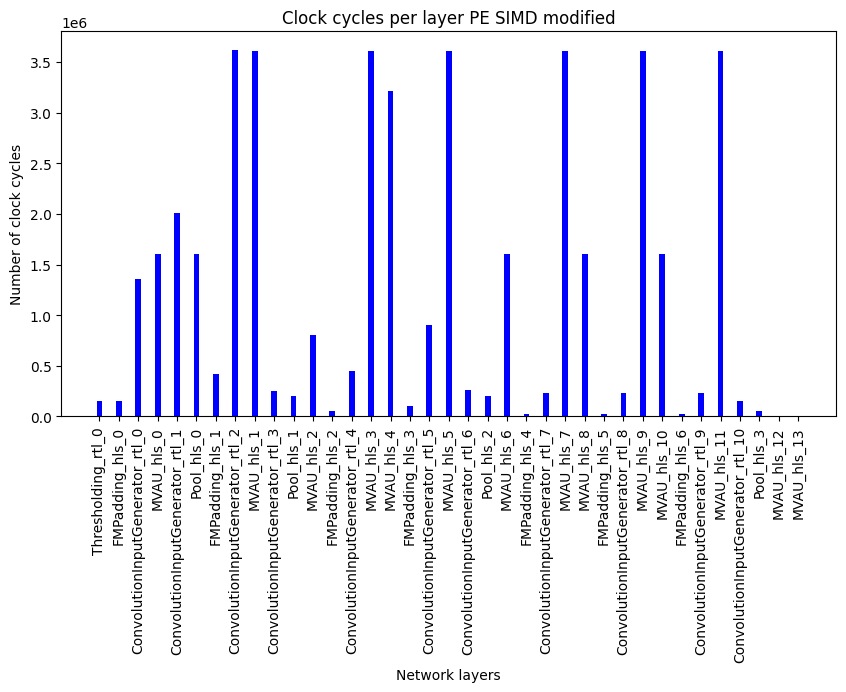

In [130]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of clock cycles")
plt.title("Clock cycles per layer PE SIMD modified")
plt.show()

## Estimated Resources

In [131]:
res_dict = model.analysis(partial(res_estimation, fpgapart=fpga_part))
res_dict

{'Thresholding_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 128.0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 588,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 3,
  'BRAM_efficiency': 0.0625,
  'LUT': 2086,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 3308,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'Pool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'FMPadding_hls_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_2': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 1860,
  'URAM': 0,


### BRAM usage

In [132]:
BRAM = {key: res_dict[key]["BRAM_18K"] for key in res_dict.keys() if res_dict[key]["BRAM_18K"] != 0}

n_BRAM = 0
for k, v in BRAM.items():
    print(f'{k:<14} {v} BRAM')
    n_BRAM += v
print(f'\nTotal BRAM = {n_BRAM}')

MVAU_hls_0     3 BRAM
MVAU_hls_1     2 BRAM
MVAU_hls_2     1 BRAM
MVAU_hls_3     2 BRAM
MVAU_hls_4     1 BRAM
MVAU_hls_5     8 BRAM
MVAU_hls_6     1 BRAM
MVAU_hls_7     5 BRAM
MVAU_hls_8     1 BRAM
MVAU_hls_9     5 BRAM
MVAU_hls_10    1 BRAM
MVAU_hls_11    5 BRAM
MVAU_hls_12    1 BRAM
MVAU_hls_13    1 BRAM

Total BRAM = 37


### LUT usage

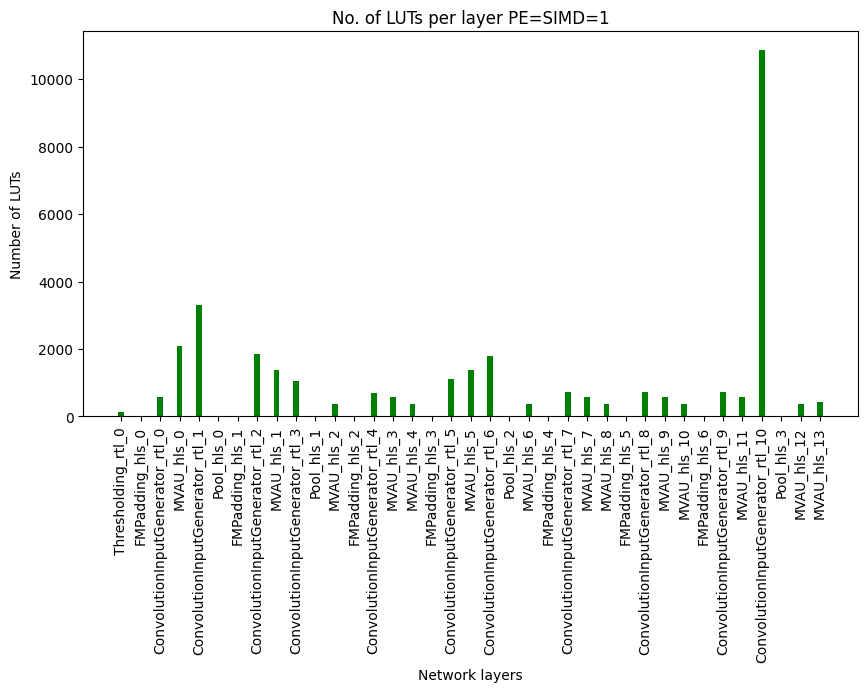

In [133]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.xticks(rotation=90)
plt.ylabel("Number of LUTs")
plt.title("No. of LUTs per layer PE=SIMD=1")
plt.show()